## 1. __Prepare Problem__
#### __Load libraries__

In [181]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
import glob
import os
import gc
##from data_prepare                  import data_prep
from tqdm.notebook                 import tqdm # progressbar
from time                          import sleep
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import pandas                      as pd
import missingno                   as msno
import statsmodels.api             as sm
from cf_matrix                     import make_confusion_matrix
from collections                   import Counter
from imblearn.over_sampling        import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN,SMOTENC
from imblearn.under_sampling       import RandomUnderSampler
from imblearn.under_sampling       import AllKNN
from imblearn.under_sampling       import InstanceHardnessThreshold
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.preprocessing         import MinMaxScaler
from sklearn.model_selection       import cross_validate
from sklearn.model_selection       import KFold
from sklearn.model_selection       import RepeatedStratifiedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import recall_score
from sklearn.metrics               import make_scorer
from sklearn.metrics               import fbeta_score
from sklearn.linear_model          import LogisticRegression 
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.naive_bayes           import ComplementNB
from sklearn.utils.class_weight    import compute_class_weight

from sklearn.svm                   import SVC
#from sklearn.pipeline              import Pipeline
from imblearn.pipeline             import Pipeline
from imblearn.pipeline             import make_pipeline
from sklearn.feature_selection     import SelectKBest
from sklearn.feature_selection     import chi2
from sklearn.feature_selection     import RFE
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import ExtraTreesClassifier
from imblearn.ensemble             import BalancedBaggingClassifier
from imblearn.ensemble             import BalancedRandomForestClassifier
from imblearn.ensemble             import EasyEnsembleClassifier
from sklearn.compose               import ColumnTransformer
from category_encoders             import *


from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.reset_option('all')
%matplotlib inline
data_path = '../../data_2021-may-15/'

# separate X and Y
CM_labels = ['True Neg','False Pos','False Neg','True Pos']
CM_categories = ['Zero', 'One']


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [51]:
#===================================================================
#
#===================================================================
# Re-usable functions
def value_counts_percent(df,check_list, comp=False, condition=pd.Series(),
                         New_name = None, plot=False, 
                         plt_cnf={'explode':[], 'startangle':0,
                                  'labeldistance':1.2,
                                  'labels':False, 'title':''}):
    # re-usable function
    def re_use(counts):
        percent = counts / counts.sum()        
        # Plot a pie chart
        if plot == True:
            sizes = percent
            labels = percent.index.tolist() if plt_cnf['labels']!=False else None
            explode = (plt_cnf['explode'][0],)+(plt_cnf['explode'][1],) * (len(percent)-1) if plt_cnf['explode'] !=[] else None
            plt.pie(sizes,explode=explode, labels=labels,
                    autopct='%1.0f%%', pctdistance=1.1,
                    labeldistance=plt_cnf['labeldistance'], startangle=plt_cnf['startangle'])
            
            if plt_cnf['labels']==False:
                plt.legend(percent.index.tolist(), loc="center")
            plt.title(plt_cnf['title'], fontdict = {'fontsize' : 20})
            plt.axis('equal') 
            plt.show()
        else:
            # or display it on a table
            fmt = '{:.2%}'.format        
            display(pd.DataFrame({'+': counts, '%': percent.map(fmt)}))
    
    # if multiple columns should be shown separately
    if comp==False and condition.empty == True:
        for col in check_list:
            if col in df.columns:
                counts = df[col].value_counts(dropna=False)
                counts.index.name = col 
                re_use(counts)
                print('\n')
    # if multiple columns should be shown @ the same table            
    elif comp== True:
        counts = df[check_list].value_counts()        
        re_use(counts)
    # if one column should be shown based on a condition    
    elif condition.empty == False:
        counts = df[check_list][condition].value_counts(dropna=False) 
        counts.index.name =  New_name if New_name!= None else check_list
        re_use(counts)

<a class="anchor" id="eading--2"></a>
# 2. Data Exploration and Feature Engineering

<a class="anchor" id="heading--2-1"></a>
### 2.1. Load the data

In [156]:
# load @admission file based on 1~167 csv files 
df =  pd.read_csv(data_path+'@admission_allData.csv', low_memory=False)
print('\nDimensions of the dataset: {}'.format(df.shape))



Dimensions of the dataset: (163273, 145)


In [158]:
def groupby_(dataFrame, col, col_name):
    p=dataFrame.groupby(col).size()
    s=dataFrame[col].value_counts(normalize=True,sort=False).mul(100) 
    display(pd.DataFrame({'#'+col_name:s.index, '+':p.values, '%':s.values }))

<div id="heading--2-2"/>

## 2.2. __Data Cleanup Function__

The `mimic_cleanup` performs all of the needed data cleanup and feature engineering steps. 

In [159]:
def mimic_cleanup(df,prediction_only=False, postcode_csv='australian_postcodes.csv', verbose=True):
    '''
    preprocessing of the data frames
    
    Parameters
    ----------
    df : Pandas dataframe
        Input dataframe
    
    prediction_only : bool 
        indicates whether we are preparing data for prediction purpose the model or not
        
    postcode_csv : str 
        path to the australian post code mapping table        
   
    verbose : bool
        Displaying process completion steps

    Returns
    -------
    df : pandas dataframe
        preprocessed Dataframe  
    '''
    steps = 8
    current_step = 0    
    
    # -----------------------------------------
    # preparing data for training purpose only 
    # -----------------------------------------    
    if not prediction_only:
        # update values of cb and met columns to indicate whether an emergency call (MET / CB) occurred or not.
        df.loc[df['met'] > 0, 'met'] = 1
        df.loc[df['cb'] > 0, 'cb'] = 1

        # Feature Engineering for Length of Stay (LOS) target variable
        # Convert admission and discharge times to datatime type
        # Convert timedelta type into float 'days', 86400 seconds in a day
        df['admitdt'] = pd.to_datetime(df['admitdt'])
        df['dischargedt'] = pd.to_datetime(df['dischargedt'])
        df['LOS'] = (df['dischargedt'] - df['admitdt']).dt.total_seconds()/86400

        # Mark admissions where patients died in boolean column    
        df['died'] = df['died'].map(dict(Yes=1, No=0))
        prediction_output_list = ['met','cb', 'anycall','died', 'LOS']
        if verbose: 
            current_step +=1
            print(f'({current_step}/{steps}) Completed training purpose data engineering')
    
    # -----------------------------------------
    #            renaming the columns 
    # -----------------------------------------  
    rename_dict = {'recordTime': 'dt', 'cVisitNumber': 'visit','cAdmissionNumber':'visit','URNumber': 'urno', 'Age': 'age','Sex': 'sex', 
                   'Indig': 'indig','cAdmitDateTime': 'cadttext', 'cWard': 'cward','cBed': 'cbed', 'cUnit': 'cunit','cSource': 'csource',
                    'cAdmitClass': 'cadmitclass','cPvtHealth': 'cpvthlth', 'cAdmitMBS': 'cadmitmbs','cExptStay': 'cexpstay',
                    'eVisitNumber': 'evisit','eAdmissionNumber':'evisit','eComplaintCode': 'ecomplaintcode','eComplaint': 'ecomplaint',
                    'pUnit': 'punit','eTriageCat': 'etriage','cICU': 'cicu','cTheatre': 'ctheatre', 'pVisitNumber': 'pvisit','pAdmissionDate':'padmdtext',
                    'pLengthOfStay': 'plos','IndexOfComorbidity': 'pcomorbid', 'ageonadmission': 'ageadmission','AgeRelatedRisk': 'agerisk',
                    'CombinedScore': 'combinedscore','Estimated10YearSurvival': 'survive10', 'c_MI': 'c_mi','c_chf': 'c_chf', 'c_pvd': 'c_pvd',
                    'c_cvd': 'c_cvd','c_dementia': 'c_dementia', 'c_cpd': 'c_cpd','c_ctd': 'c_ctd', 'c_pud': 'c_pud',
                    'c_mld': 'c_mld','c_dmnc': 'c_dmnc', 'c_dmcc': 'c_dmcc','c_hemi': 'c_hemi', 'c_renal': 'c_renal',
                    'c_cancer': 'c_cancer','c_ld': 'c_ld', 'c_metca': 'c_metca','c_aids': 'c_aids', 'pP1': 'pdiag',
                    'pP1Desc': 'pdiagd','pProc1': 'pproc', 'pProcDesc': 'pprocd','pCall': 'pcall', 'pICU': 'picu','pH': 'ph', 'BiCarb': 'bicarb',
                    'Lactate': 'lactate','Hb': 'hb', 'WCC': 'wcc','Creatinine': 'creatinine', 'Platelets': 'platelets',
                    'PostCode': 'postcode','AdvantageAndDisadvantageDecile': 'sadd', 'RelativeSocioEconomicDisadvantageDecile': 'srsd',
                    'EconomicResourcesDecile': 'ser','EducationAndOccupationDecile': 'seo', 'ipInLast1Years': 'ip12m',                    
                    'ipInLast2Years': 'ip24m','EDInLast1Years': 'ed12m', 'EDInLast2Years': 'ed24m','isAtRisk': 'atrisk', 'uniqueID': 'id',
                    'pFrailtyScore': 'frailty'
                     }
    # rename the columns to what the model was learned
    df.rename(rename_dict,inplace=True)
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed renaming columns')    
    
    # -----------------------------------------
    #            filtering the columns 
    # -----------------------------------------  
    # filtering the columns based on live data columns
    columns_filter_list = ['dt','visit','urno','age','sex','indig','cadttext','cward','cbed','cunit','csource','cadmitclass',
                           'cpvthlth','cadmitmbs','cexpstay','evisit','ecomplaintcode','ecomplaint','etriage','cicu',
                           'ctheatre','pvisit','padmdtext','punit','plos','pcomorbid','ageadmission','agerisk',
                           'combinedscore','survive10','c_mi','c_chf','c_pvd','c_cvd','c_dementia','c_cpd',
                           'c_ctd','c_pud','c_mld','c_dmnc','c_dmcc','c_hemi','c_renal','c_cancer','c_ld',
                           'c_metca','c_aids','pdiag','pdiagd','pproc','pprocd','pcall','picu','ph','bicarb',
                           'lactate','hb','wcc','creatinine','platelets','postcode','sadd','srsd','ser','seo',
                           'ip12m','ip24m','ed12m','ed24m','atrisk','frailty']
    if not prediction_only:
        columns_filter_list += prediction_output_list
    df = df.filter(columns_filter_list)
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed filtering columns')  
        
    # -----------------------------------------
    #     postcode (Feature Engineering) 
    # -----------------------------------------
    # Import CSV tables
    df_pc = pd.read_csv(postcode_csv)    
    
    df['postcode'] = df['postcode'].fillna(0)
    df['postcode'] = df['postcode'].astype('int')
    
    # Merge postcode data with hospital data
    # delete postcode dataframe which not needed anymore
    df = df.merge(df_pc[['postcode','state', 'sa4','sa4name','Lat_precise','Long_precise']], on="postcode", how='left')
    del df_pc
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed postcode (Feature Engineering).')
    
    # -----------------------------------------
    #          Feature Engineering 
    # -----------------------------------------
    # sex/male feature engineering
    conditions = [
    df['sex'].eq('F'),
    df['sex'].eq('M')
    ]

    choices = [0,1]

    df['male'] = np.select(conditions, choices, default=0) # [R, f, W, X, G, I, m] --> are considered as Female    
    
    # Admission Type (Feature Engineering)   
    # handle missing data based on elective info
    col = 'etriage'    
    if col in df.columns:
        if 'elective' in df.columns.tolist():
            df[col] = df[col][df.elective==0].fillna(0) # ******  Not elective but missed  value! **************
            df[col] = df[col].fillna(6)                 # elective
            
        else:
            # etriage missing value handling
            df[col] = df[col].fillna(0)
            
            # Adding 'elective' column
            # create a list of our conditions
            conditions = [
                (df[col] == 0),
                (df[col] > 0)
                ] 
            
            # create a list of the values we want to assign for each condition
            values = [0, 1]
            
            # create a new column and use np.select to assign values to it using our lists as arguments
            df['elective'] = np.select(conditions, values)
            
    # ICD-10-AM Code (Feature Engineering) 
    if 'icd10' in df.columns.tolist():           
        df['icd10Chapter'] = df['icd10'].astype(str).str[0]
        sub_chapte = df['icd10'].astype(str).str[1:3].astype('int')
        # replace 'neoplasms'
        df['icd10Chapter'] = np.where(df['icd10Chapter'] =='C'  , 'C/D', df['icd10Chapter'])
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='D') & (sub_chapte<49) , 'C/D', df['icd10Chapter'])
        # replace 'Infectious'
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='A') | (df['icd10'].astype(str).str[0]=='B') , 'AB', df['icd10Chapter'])
        # replace 'injury'
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='S') | (df['icd10'].astype(str).str[0]=='T') , 'S/T', df['icd10Chapter'])
        # replace 'ex morbility'
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='V') | (df['icd10'].astype(str).str[0]=='Y') , 'V-Y', df['icd10Chapter'])

        # Associated category names
        diag_dict = {'AB': 'Infectious', 'C/D': 'Neoplasms', 'D': 'Blood',
                     'E': 'Endocrine', 'F': 'Mental', 'G': 'Nervous', 'H': 'Eye/Ear',
                     'I': 'Circulatory', 'J': 'Respiratory', 'K': 'Digestive', 'L': 'Skin', 
                     'M': 'Muscular', 'N': 'Genitourinary', 'O': 'Pregnancy', 'P': 'Prenatal',
                     'Q': 'Congenital', 'R': 'Symptoms', 'S/T': 'Injury',
                     'U-V': 'Morbidity', 'Z': 'misc'}
        df['ICD10AM'] = df['icd10Chapter'].replace(diag_dict)
        
    # Age (Feature Engineering)
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 120]
    labels = [1,2,3,4,5,6,7,8,9] #['<20','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','+90']
    df['age_range'] = pd.cut(df.age, bins, labels = labels,include_lowest = True)
    
    
    # -----------------------------------------
    # 'outlier' column data engineering
    # -----------------------------------------
    # create a new column filled with ones
    #df['outlier'] = 1
    
    # create a list of our conditions
    not_outlier_conditions = [
        (df['cward'] == "IC1") | (df['cward'] == "EMU" ) | (df['cward'] == "EOU") | (df['cward'] == "DP1") | (df['cward'] == "SUB"),
        (df['cunit'] == "ACE") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "BRE") &  (df['cward'] == "7E" ),
        (df['cunit'] == "CAR") & ((df['cward'] == "4W" ) | (df['cward'] == "CCU") | (df['cward'] == "4E")), 
        (df['cunit'] == "CTS") &  (df['cward'] == "4E" ),
        (df['cunit'] == "DER") &  (df['cward'] == "10E"),
        (df['cunit'] == "DOS") & ((df['cward'] == "7E" ) | (df['cward'] == "7W" )), 
        (df['cunit'] == "END") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "ENT") &  (df['cward'] == "5W" ),
        (df['cunit'] == "ESO") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "ESS") & ((df['cward'] == "EMU") | (df['cward'] == "EOU")),
        (df['cunit'] == "FMS") & ((df['cward'] == "9W" ) | (df['cward'] == "5W" )),
        (df['cunit'] == "GAS") & ((df['cward'] == "7E" ) | (df['cward'] == "7W" )),
        (df['cunit'] == "GMA") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GMB") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GMC") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GMD") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GME") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GS1") & ((df['cward'] == "7W" ) | (df['cward'] == "7E" )),
        (df['cunit'] == "GS3") & ((df['cward'] == "7W" ) | (df['cward'] == "7E" )),
        (df['cunit'] == "HAE") &  (df['cward'] == "6W"),
        (df['cunit'] == "IDU") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "N/L") &  (df['cward'] == "10E"),
        (df['cunit'] == "N/S") &  (df['cward'] == "10W"),
        (df['cunit'] == "ONC") &  (df['cward'] == "6W" ),
        (df['cunit'] == "ORT") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "PLA") &  (df['cward'] == "5W" ),
        (df['cunit'] == "PSN") &  (df['cward'] == "PSN"),
        (df['cunit'] == "REN") &  (df['cward'] == "10E"),
        (df['cunit'] == "RES") & ((df['cward'] == "4E" ) | (df['cward'] == "4W" )),
        (df['cunit'] == "RHU") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "STR") &  (df['cward'] == "10E"),
        (df['cunit'] == "URO") &  (df['cward'] == "7W" ),
        (df['cunit'] == "VAS") &  (df['cward'] == "5W" )
        ]

    # create a list of the values we want to assign for each condition
    not_outlier_values = [0] * len(not_outlier_conditions)

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['outlier'] = np.select(not_outlier_conditions, not_outlier_values, default=1)
    # fill nan with 1
    #df['outlier'] = df['outlier'].fillna(1)

    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed Feature Engineering')
    
    # -----------------------------------------
    #        Droping useless columns 
    # -----------------------------------------
    columns_to_remove = ['sex', 'pproc','pdiagd','pprocd','ecomplaint','elective2', 'diagnosis',                                        # redundante       -'pdiag' ,'nhin','statin','transin', ,'cunit'
                         #'vascular','stroke','respiratory','renal','nsurg','genmed','cts','gensurg','ort','ent','card',                # redundante in (unitcode)
                         'sa4name', 'etriage_cat','icd10Chapter','age',                                                                 # redundante
                         'cadmitmbs','icd10', 'ICD10AM',                                                                                # codded     -           
                         'drg', 'wies', 'period', 'outcome', 'arrest',                                                                  # outcome/leakage  -'died', 'survive10', 'agerisk', 'cexpstay'
                         'anyarrest', 'call','atrisk',                                                                                  # outcome/leakage  -hiout, 'met', 'cb', 'anycall', 'cicu','ctheatre',  
                         'cbed','postcode',                                                                                             # location
                         'dt','cadttext','padmdtext','rdt','cadt','padt','admitdt','adt','dischargedt','ddt', 'sequencelos',            # date/time
                         'dobt', 'dodt', 'ad','dd' ,'dob', 'dod', 'eventdate','ageadmission',                                           # date/time
                         'id', 'Unnamed: 0','sequence','pvisit','urno','visit',                                                         # id                ,  
                         'phc','bicarbc','lactatec','hbc','wccc','creatininec','plateletsc','phc2','bicarbc2','lactatec2','hbc2',       # useless
                         'wccc2','creatininec2','plateletsc2',                                                                          # useless
                         'evisit','punit','plos' ,'Lat_precise','Long_precise','pcall','frail2' ,'frail3',                              # useless                   
                        ]
    new_columns = [col for col in df.columns.tolist() if col not in columns_to_remove]
    df = df[new_columns]
    
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed Droping useless columns')
    
    # Missing Values   
    fillna_list = ['survive10','frailty','pcomorbid','combinedscore','sadd','srsd','ser','seo',
                   'ecomplaintcode', 'sa4','state', 'pdiag','diagnosis', 'cadmitmbs','icd10',
                  'agerisk']
    for col in fillna_list:
        if col in df.columns.tolist():
            df[col] = df[col].fillna(-1)

    if 'hiout' in df.columns.tolist():
        df = df[df['hiout'].notna()]

    # Recategorization
    binary_cols = ['frail2', 'hiout', 'edvisit']#,'outlier']
    for col in binary_cols:
        if col in df.columns.tolist():
            if col != 'frail2':
                df[col] = df[col].map({'Yes': 1, 'No': 0})
            else:
                df[col] = df[col].map({'Frail': 1, 'Normal': 0})    
        
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed missing value handeling') 
        
    # -----------------------------------------
    #        data type conversion
    # -----------------------------------------
    # Convert dtype of some columns to int
    int_columns = ['etriage', 'pcomorbid','agerisk','combinedscore','sa4', 'combinedscore', 'srsd', 'ser', 'seo','sadd']
    df[int_columns] = df[int_columns].astype('int')
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed data type conversion') 

    if verbose: 
        print('Data Preprocessing complete.')
    
    print('Total Number of remained missing values --> {}'.format(df.isna().sum().sum()))
    print('Dimensions of the final dataset: {}\n'.format(df.shape))
    
    return df

In [163]:
def mimic_prepare_DF(dataframe, features, one_hot_cols, target, verbose=True):
    '''
    Prepare data frames for model training
    
    Parameters
    ----------
    dataframe : Pandas dataframe
        Input dataframe
    
    features : list 
        list of top features name
    one_hot_cols : list 
        list of top features name
    target  : str
        The name of the column that will be used for output.         
    verbose : bool
        Displaying process completion steps

    Returns
    -------
    dataframe : pandas dataframe
        prepared Dataframe
    categorical_ix : list
        list of columns selected for target encoding    
    '''
    
    if target not in dataframe.columns:
        raise ValueError('%s is not a column in the dataframe' % (target))

    ## Step 1 --> One hot encoding
    dataframe = pd.get_dummies(dataframe, columns=one_hot_cols)
    one_hot_columns_name = [s for s in dataframe.columns.tolist() if any(xs in s for xs in one_hot_cols)]
    if verbose: 
        print('(1/3) Completed One hot encoding')
        
    ## Step 2 -->  Select top features
    dataframe = dataframe[features+one_hot_columns_name+ [target]]    
    if verbose: 
        print('(2/3) Copmleted top feature selection')
        
    ## Step 3 -->  Reordering the columns
    '''
    Reordering the columns to prepare them for ColumnTransformer
    Because the ColumnTransformer will rearrange the columns and forget the names
    '''
    # Select numerical and categorical columns
    numerical_ix   = dataframe.select_dtypes(include=['int64', 'float64', 'category', 'uint8']).columns
    categorical_ix = dataframe.select_dtypes(include=['object', 'bool']).columns
    # reorder the columns name
    reordered_cols =  list(categorical_ix)+list(numerical_ix)
    dataframe = dataframe[reordered_cols]
    if verbose: 
        print('(3/3) Completed column reordering')
    print('Dimensions of the final dataset: {}\n'.format(dataframe.shape))
    return dataframe, categorical_ix

In [161]:
#train_ad_path   = data_path+'@admission_all.csv'
#test_ad_path    = data_path+'@admission_val.csv'
post_path = 'australian_postcodes.csv'

target = 'met'
# apply data cleanup
df = mimic_cleanup(df)

(1/8) Completed training purpose data engineering
(2/8) Completed renaming columns
(3/8) Completed filtering columns
(4/8) Completed postcode (Feature Engineering).
(5/8) Completed Feature Engineering
(6/8) Completed Droping useless columns
(7/8) Completed missing value handeling
(8/8) Completed data type conversion
Data Preprocessing complete.
Total Number of remained missing values --> 0
Dimensions of the final dataset: (768211, 61)



In [162]:
with pd.option_context('display.max_colum', None):
    display(df.tail(1))


,indig,cward,cunit,csource,cadmitclass,cpvthlth,cexpstay,ecomplaintcode,etriage,cicu,ctheatre,pcomorbid,agerisk,combinedscore,survive10,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,met,cb,anycall,died,LOS,state,sa4,male,elective,age_range,outlier
768210,0,EOU,ESS,HME,EMD,1,999,-1,0,0,0,-1,-1,-1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,7.4,25,1.5,173,6.5,81,236,3,1,1,9,0,0,0,0,-1.0,0,0,0,0,0.072917,VIC,206,1,0,6,0


### 2. Imbalanced dataset

    * Check out data imbalance  
    * Oversampling

The anycall classes follows an imbalance distribution since the majority of patients have anycall=0 (99%).

In [66]:
for col, col_name in zip([target],[target]):
    groupby_(df, col, col_name+'_train')


,#met_train,+,%
0,0,752115,97.904742
1,1,16096,2.095258


* __Separate categorical and Numerical features__

In [164]:
prediction_output_list = ['met','cb', 'anycall','died', 'LOS']
# name of dependant variable
target = 'met'
# list of columns which are selected as the One hot encoding scheme.
one_hot_cols    = ['csource', 'cadmitclass', 'state']
# selected features which are the most important features for the prediction purpose
features    = df.columns.tolist()
features = [x for x in features if x not in prediction_output_list]
features = [x for x in features if x not in one_hot_cols]

# preparing data for the prediction step
df_met, target_enc_cols = mimic_prepare_DF(df, features, one_hot_cols, target)

(1/3) Completed One hot encoding
(2/3) Copmleted top feature selection
(3/3) Completed column reordering
Dimensions of the final dataset: (768211, 76)



* __Splitting Data__

In [165]:
df_train, df_test = train_test_split(df_met,  stratify = df[target],
                                     test_size = 0.3,
                                     random_state = 42)
# Train and test split
X_train, y_train = df_train.drop(  [target], axis=1) , df_train  [target]
X_test,  y_test  = df_test.drop([target], axis=1) , df_test[target]


In [166]:
encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), target_enc_cols )], remainder='passthrough')
scaler  = MinMaxScaler()

# apply encoding on categorical features and then scale the be in standard form (zero mean and unit variance)
X_train_enc = encoder.fit_transform(X_train, y_train)
#X_trans = encoder.fit_transform(X_trans)

In [167]:
with pd.option_context('display.max_colum', None, 'display.max_rows', None):
    display(X_test.head())

,cward,cunit,ecomplaintcode,pdiag,indig,cpvthlth,cexpstay,etriage,cicu,ctheatre,pcomorbid,agerisk,combinedscore,survive10,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,sa4,male,elective,age_range,outlier,csource_E,csource_HME,csource_HWL,csource_N,csource_R,csource_S,csource_T,csource_TRC,csource_zPN,cadmitclass_EAD,cadmitclass_EMD,cadmitclass_O,cadmitclass_S,state_-1,state_ACT,state_NSW,state_NT,state_QLD,state_SA,state_TAS,state_VIC,state_WA
659959,9E,ORT,-1,M67.85,0,0,4,0,0,1,0,3,3,0.775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.40,25,1.5,120,9.0,90,250,5,5,6,5,0,1,0,0,0.0,211,0,0,7,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
654327,5W,ENT,-1,-1,0,1,7,0,0,1,-1,-1,-1,-1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.40,25,1.5,147,7.6,91,241,3,4,4,5,0,0,0,0,-1.0,215,1,0,8,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
634501,7W,GS1,-1,-1,0,1,0,0,0,0,-1,-1,-1,-1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.40,25,1.5,120,9.0,90,250,4,4,3,4,0,0,0,0,-1.0,205,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
251559,8E,GMA,SEP,I25.5,0,0,0,2,0,0,3,3,6,0.022,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7.32,29,1.2,123,7.6,100,184,8,9,9,7,1,1,0,0,6.1,204,1,1,7,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
166963,9W,ORT,-1,D16.8,0,0,0,0,0,0,0,2,2,0.901,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.40,25,1.5,130,5.3,90,321,2,2,3,2,1,1,0,0,0.0,215,1,0,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


### 2.5 Feature Selection
* __methods generating under-sampled subsets combined inside an ensemble__

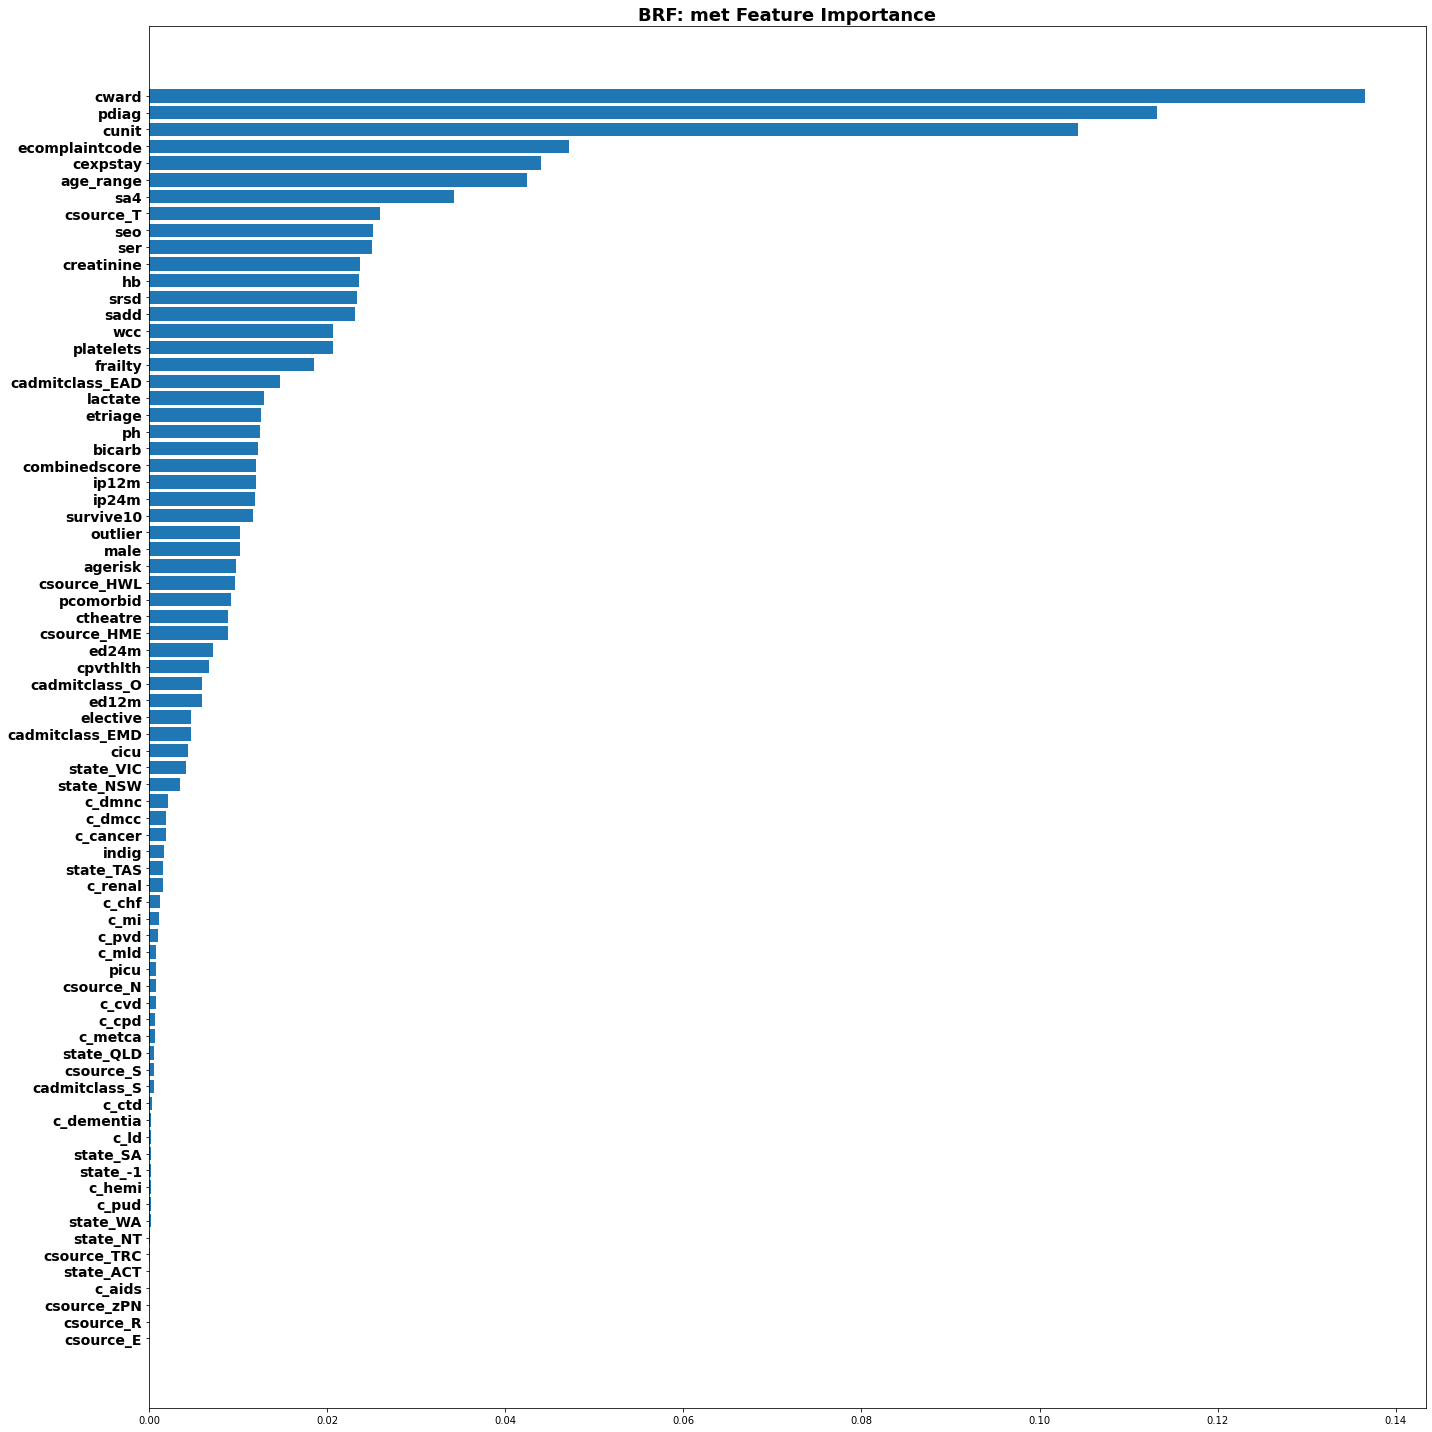

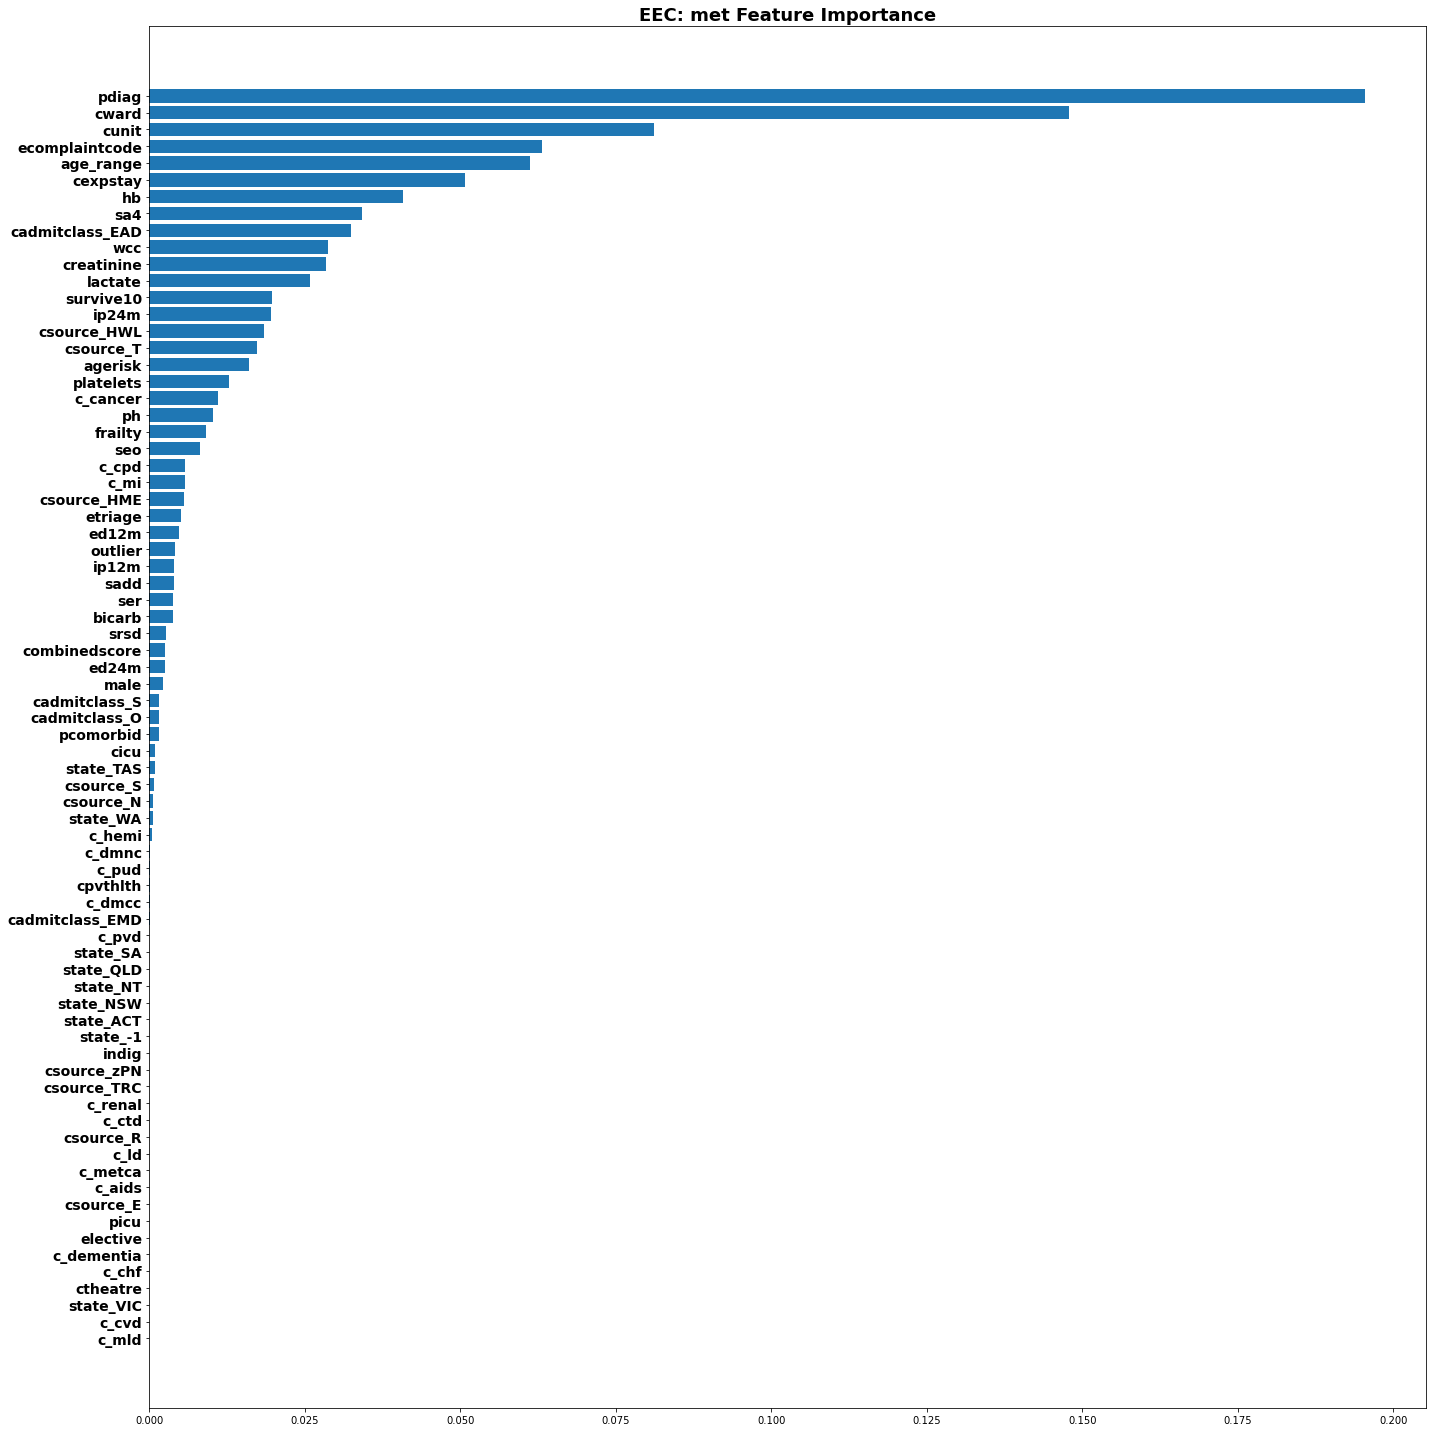

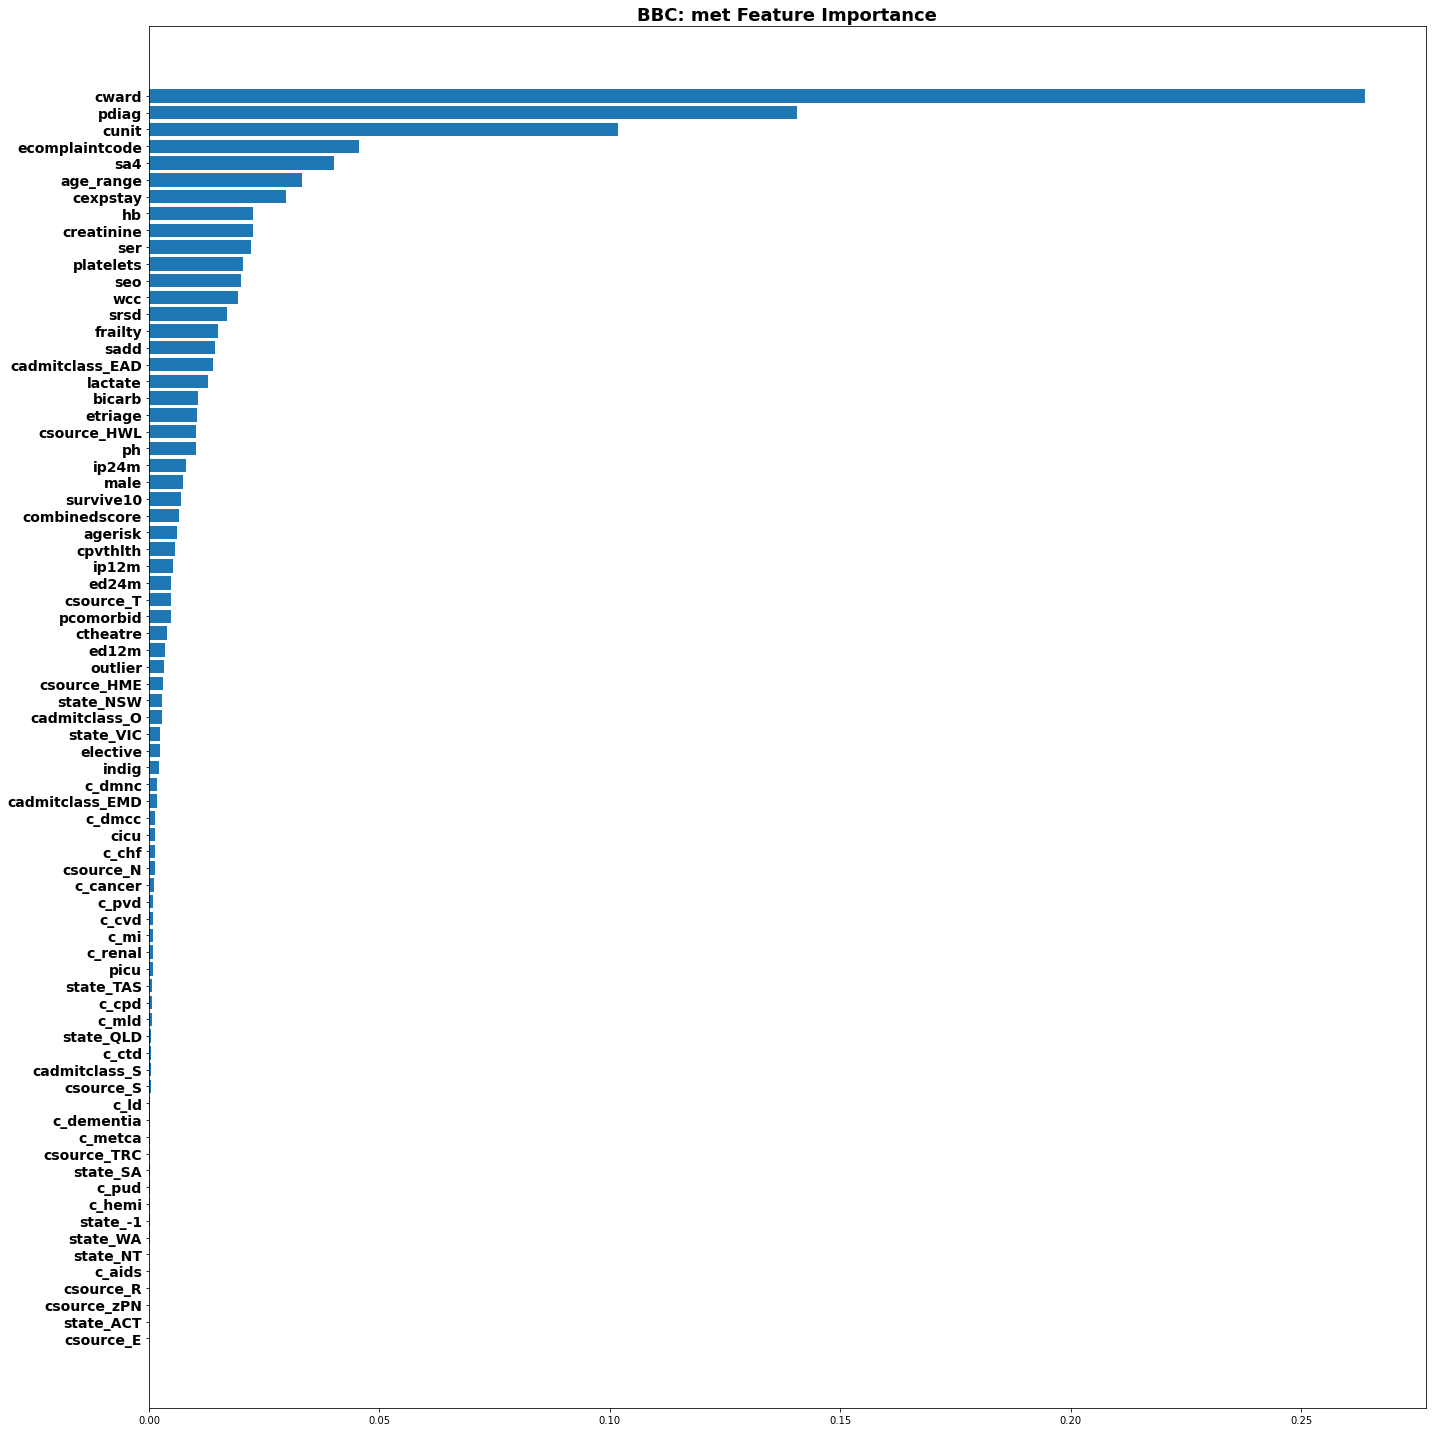

37976

In [168]:

cols = list(X_train.columns)
plt.rcParams['figure.figsize'] = (20.0, 20.0)

def plot_importance(indices, feature_importances, title):    
    sorted_idx = indices[::-1]
    feature_names = np.array(cols)[sorted_idx].tolist()
    y_ticks  = np.arange(0, len(feature_names)) 
    fig, ax = plt.subplots()
    ax.barh(y_ticks,feature_importances[sorted_idx], align='center')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names, weight = 'bold', fontsize=14)
    ax.set_title(title, weight = 'bold', fontsize=18)
    fig.tight_layout()
    #plt.savefig('Fimportance.png')
    plt.show()
    

def get_models():
    models, names = list(), list()
    
    # BRF
    models.append( BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1))
    names.append('BRF')
    # EEC
    models.append( EasyEnsembleClassifier(n_estimators=100, n_jobs=-1)) 
    names.append('EEC')
    # BBC
    models.append( BalancedBaggingClassifier(n_estimators=100, n_jobs=-1))
    names.append('BBC')
    return models, names

indeces = []
# define models
models, names = get_models()
# evaluate each model
for i in range(len(models)):
    model = models[i]
    fit = model.fit(X_train_enc, y_train)
    if names[i] == 'BRF':
        importance = -model.feature_importances_
    elif names[i] == 'BBC' or 'EEC':
        importance = -(np.mean([est.steps[1][1].feature_importances_ for est in model.estimators_], axis=0))
    indices_ = np.argsort(importance)
    selected_features_names = np.array(cols)[indices_]
    
    mv_df = pd.DataFrame({'anycall Features importance':np.array(selected_features_names)})
    #with pd.option_context('display.max_columns', None): 
    #    display(mv_df.T)
    indeces.append(indices_)
    plot_importance(indices_, -importance, names[i]+': '+target+' Feature Importance')
gc.collect()

* __Fnding 70 most voted (important) features__

In [169]:
Num_of_imp_features = 70
most_vote_dict = {k: v for v, k in enumerate(indeces[0])}

ind_list = [indeces[1], indeces[2]]
for lst in ind_list:
    for v, k in enumerate(lst):
        most_vote_dict[k] +=v

most_vote_sorted = {k: v for k, v in sorted(most_vote_dict.items(), key=lambda item: item[1])}
MV_ind = list(most_vote_sorted.keys())
mv_df = pd.DataFrame({'70 Most important features':np.array(cols)[MV_ind[:Num_of_imp_features]]})
with pd.option_context('display.max_columns', None): 
    display(mv_df.T)

# Select important features
top_70_features = list(np.array(cols)[MV_ind[:Num_of_imp_features]])

X_Train = X_train[top_70_features]
print('\nData shape: X:{}  & y:{}'.format(X_Train.shape,y_train.shape))

# handling ram usage
del  cols, Num_of_imp_features, most_vote_sorted
gc.collect()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
70 Most important features,cward,pdiag,cunit,ecomplaintcode,age_range,cexpstay,sa4,hb,creatinine,wcc,seo,cadmitclass_EAD,platelets,lactate,ser,frailty,csource_T,srsd,sadd,ip24m,ph,survive10,etriage,csource_HWL,bicarb,agerisk,ip12m,combinedscore,male,outlier,csource_HME,ed12m,ed24m,pcomorbid,cpvthlth,cadmitclass_O,c_cancer,cicu,c_mi,c_dmnc,cadmitclass_EMD,state_NSW,c_cpd,ctheatre,c_dmcc,state_TAS,csource_N,indig,elective,c_pvd,state_VIC,cadmitclass_S,c_renal,csource_S,c_chf,state_QLD,picu,c_hemi,c_cvd,c_pud,c_ctd,state_SA,state_WA,c_mld,c_metca,c_ld,state_-1,state_NT,c_dementia,csource_TRC



Data shape: X:(537747, 70)  & y:(537747,)


0

*  #### __TopFeature performance__

In [182]:
space = [10,20,30,40,50,60,70]
# define models to test
model = Pipeline(steps=[('prep',Enc),('m',BalancedRandomForestClassifier(n_estimators=200,
                                                                                   class_weight={1: 1, 0: 5},
                                                                                   sampling_strategy='not minority',
                                                                                   n_jobs=-1))])
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)

for ind in space:
    X = X_train[top_70_features[0:ind]]
    # evaluate the pipeline
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    scores = cross_val_score(model, X, y_train, scoring=metric, cv=cv, n_jobs=-1, error_score='raise')
    # report pipeline performance
    print('Recall top %s: %.3f (%.3f)' % (str(ind), np.mean(scores), np.std(scores)))

Recall top 10: 0.911 (0.002)
Recall top 20: 0.937 (0.001)
Recall top 30: 0.943 (0.004)
Recall top 40: 0.941 (0.003)
Recall top 50: 0.944 (0.002)
Recall top 60: 0.943 (0.005)
Recall top 70: 0.943 (0.005)


In [197]:
space = list(range(48,65,2))
# define models to test
model = Pipeline(steps=[('prep',Enc),('m',BalancedRandomForestClassifier(n_estimators=200,
                                                                                   class_weight={1: 1, 0: 5},
                                                                                   sampling_strategy='not minority',
                                                                                   n_jobs=-1))])
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)

for ind in space:
    X = X_train[top_70_features[0:ind]]
    # evaluate the pipeline
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    scores = cross_val_score(model, X, y_train, scoring=metric, cv=cv, n_jobs=-1, error_score='raise')
    # report pipeline performance
    print('Recall top %s: %.3f (%.3f)' % (str(ind), np.mean(scores), np.std(scores)))

Recall top 48: 0.944 (0.002)
Recall top 50: 0.940 (0.002)
Recall top 52: 0.942 (0.004)
Recall top 54: 0.945 (0.004)
Recall top 56: 0.943 (0.003)
Recall top 58: 0.944 (0.004)
Recall top 60: 0.943 (0.003)
Recall top 62: 0.942 (0.006)
Recall top 64: 0.940 (0.006)


In [199]:
# Class Weights
# Sklearn based models generally have parameter called as "class_weight" to adjust class weights.
# With using compute_class_weight function from sklearn.utils.class_weight, we can learn our class weights.
class_weights = compute_class_weight("balanced", classes = np.unique(y_train), y = y_train)
scale_pos_weight = class_weights[1]/class_weights[0]
print(f"Unique classes are: {np.unique(y_train)}, class weightd are: {class_weights}, and the scale_pos_weight is {scale_pos_weight}")

Unique classes are: [0 1], class weightd are: [ 0.51070031 23.8638058 ], and the scale_pos_weight is 46.72761160912399


*  #### __Top Features__

In [208]:
X_train = X_train[top_70_features[0:54]]
X_test  = X_test [top_70_features[0:54]]

target_enc_cols_new = [cat for cat in target_enc_cols if cat in top_70_features]
Enc = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), target_enc_cols_new )], remainder='passthrough')

## 3. Imbalanced Classification

*  ### 2.5. __Best models__ : precision_recall_curve comparison

In [151]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
def get_models():
    models, names = list(), list()
    model_1 = LogisticRegression(C=3, solver='lbfgs', class_weight='balanced',n_jobs=-1)
    #poly_reg = PolynomialFeatures(degree=2)
   
    # LR
    models.append(Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('m',model_1)]))#
    names.append('LR')
    
    # LR
    #models.append(Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('p', poly_reg),('m',model_1)]))#
    #names.append('pLR')   
    
    # CNB
    #models.append(Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('m',ComplementNB())]))#
    #names.append('CNB')
    
    # RUSC
    #models.append(Pipeline(steps=[('prep',Enc),('m',RUSBoostClassifier(n_estimators=150))]))#) # 
    #names.append('RUSC') 
    
    # BRF
    models.append(Pipeline(steps=[('prep',Enc),('m',BalancedRandomForestClassifier(n_estimators=200,
                                                                                   class_weight={1: 1, 0: 5},
                                                                                   sampling_strategy='not minority',
                                                                                   n_jobs=-1))]))
    names.append('BRF')   
    
    ## EEC
    #models.append(Pipeline(steps=[('prep',Enc),('m',EasyEnsembleClassifier(n_estimators=150, n_jobs=-1))]))#
    #names.append('EEC')
   
    
    return models, names

In [201]:
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import average_precision_score

# evaluate a model
def PRC_model(X_tr, y_tr, X_tst, y_tst,  model):
    # define evaluation procedure
    model.fit(X_tr, y_tr)
    probs = model.predict_proba(X_tst)[:, 1]    

    precision, recall, _ = precision_recall_curve(y_tst, probs)
    auc_ = auc(recall, precision)
    
    prediction = model.predict(X_tst)
    average_precision = average_precision_score(y_tst, prediction)

    return precision, recall, auc_, average_precision

def PRC_models(models, names, results):
    baseline_model = sum(y_test == 1) / len(y_test)
    
    plt.figure(figsize=(20, 10))
    plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline model')    
    
    # evaluate each model
    for i in range(len(models)):
        # evaluate the model and store results
        precision, recall, auc_, average_precision = PRC_model(X_train, y_train, X_test, y_test, models[i])
        plt.plot(recall, precision, label='AUC ({}): {:.2f}'.format(names[i], auc_))
        print('{}: precision: {}, recall: {}, auc_: {}, Average precision-recall: {}'.format(names[i],np.mean(precision),np.mean(recall), auc_, average_precision))
        
     
    # plot the results
    plt.title('Precision-Recall Curve', size=20)
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.legend();
    plt.show()

LR: precision: 0.058756935533954176, recall: 0.838445337589354, auc_: 0.15712693251957704, Average precision-recall: 0.05932707366971691
BRF: precision: 0.3692265074620903, recall: 0.8928552283952981, auc_: 0.9011306730163603, Average precision-recall: 0.1513397723154863


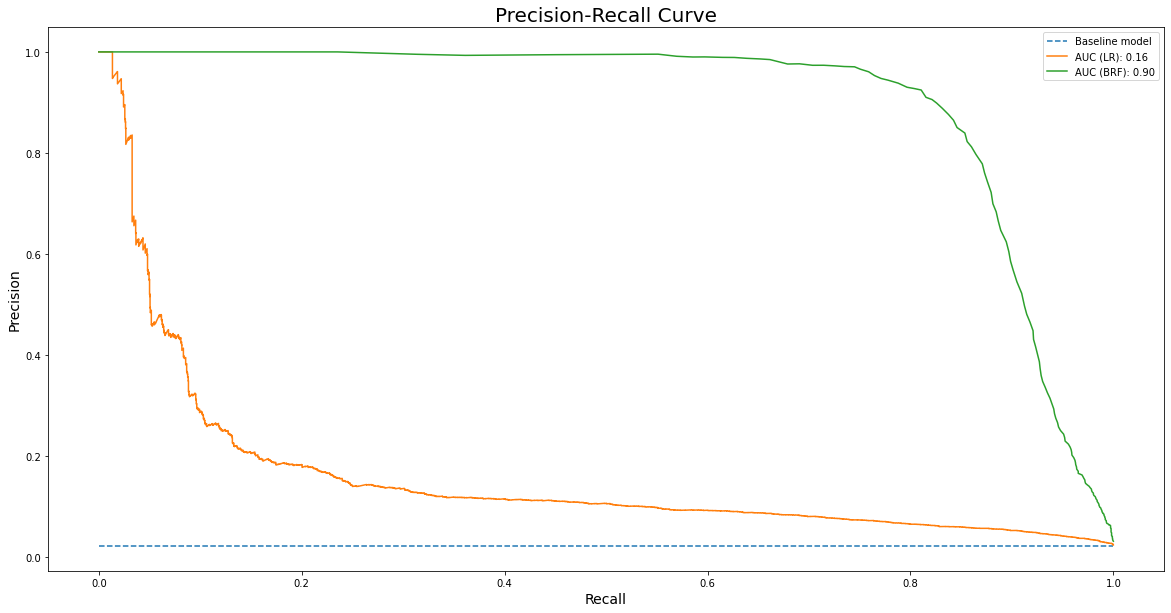

In [153]:
models, names = get_models()
results = list()
PRC_models(models, names, results)

In [200]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def evaluate_models(models, names, results):
    # evaluate each model
    for i in range(len(models)):
        # evaluate the model and store results
        scores = evaluate_model(X_train, y_train, models[i])
        results.append(scores)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    # plot the results
    plt.boxplot(results, labels=names, showmeans=True)
    plt.show()

In [254]:
def get_models():
    models, names = list(), list()
    model_1 = LogisticRegression(C=3, solver='lbfgs', class_weight='balanced',n_jobs=-1)
    model_2 = BalancedRandomForestClassifier(n_estimators=200,
                                             class_weight={1: 1, 0: 5},
                                             sampling_strategy='not minority',
                                             n_jobs=-1) 
    model_3 = BalancedBaggingClassifier(n_estimators=500, n_jobs=-1)
    
    # LR
    models.append(Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('m',model_1)]))#
    names.append('LR') 
    
    # BRF
    models.append(Pipeline(steps=[('prep',Enc),('m',model_2)]))
    names.append('BRF') 
    
    # IHT
    #models.append(Pipeline(steps=[('columntransformer',Enc),('Under', InstanceHardnessThreshold()),('m',model_2)]) )
    #names.append('IHT')
    
    # BBC
    models.append(Pipeline(steps=[('columntransformer',Enc),('m',model_3)]) )
    names.append('BBC')
    
    # EEC
    #models.append(Pipeline(steps=[('prep',Enc),('m',EasyEnsembleClassifier(n_estimators=150, n_jobs=-1))]))#
    #names.append('EEC')   
    
    return models, names

LR: precision: 0.05762476186800675, recall: 0.8389161579790335, auc_: 0.1517534985449428, Average precision-recall: 0.058100222359314495
BRF: precision: 0.36506218365763243, recall: 0.8870345186832989, auc_: 0.8889615672398281, Average precision-recall: 0.14929332883430652
BBC: precision: 0.36501691929301966, recall: 0.8705917683583332, auc_: 0.8558758417129079, Average precision-recall: 0.19330628183098672


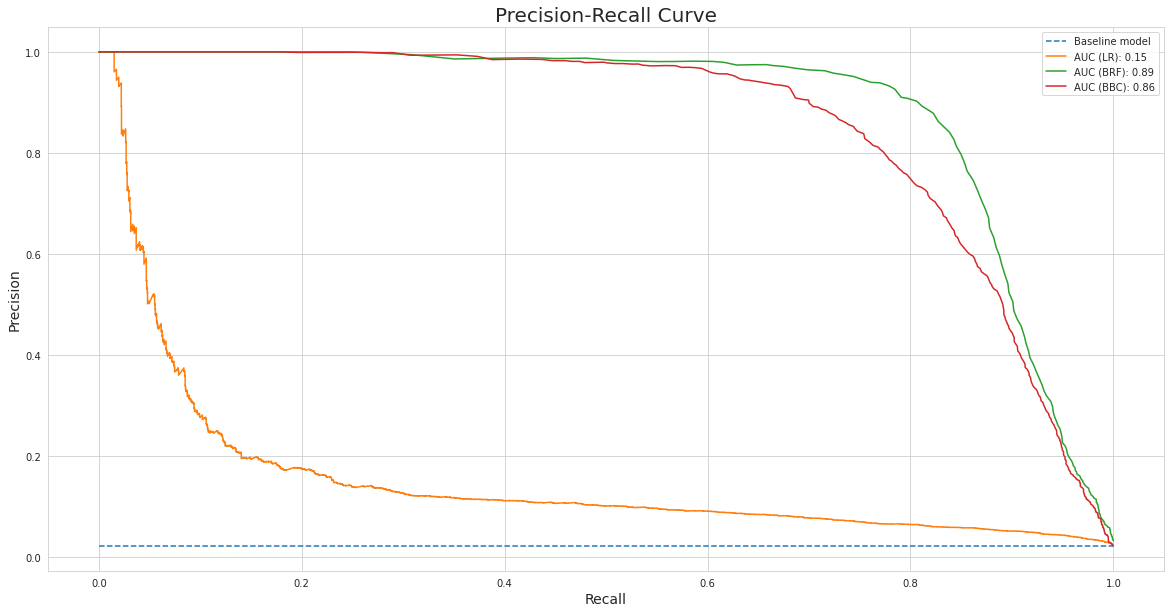

In [255]:
# define models
models, names = get_models()
results = list()
PRC_models(models, names, results)

### 2.6 __Hyperparameter Tuning__ 


In [259]:
def get_models():
    models, names, spaces= list(), list(), list()
   
    '''# LR
    pipeline_lr = Pipeline(steps=[('columntransformer',Enc),('t1', MinMaxScaler()), ('model', LogisticRegression(class_weight='balanced', n_jobs=-1))])
    # define grid
    grid = dict()
    grid['model__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    grid['model__penalty'] = ['l1','l2',None]
    grid['model__C'] = [3,5,7]
    models.append(pipeline_lr)#
    names.append('LR') 
    spaces.append(grid)'''
    
    # EEC
    #model =  BalancedBaggingClassifier(n_jobs=-1)
    model = BalancedRandomForestClassifier( n_jobs=-1)
    pipeline_brf = Pipeline(steps=[('columntransformer',Enc),
                                   ('model', model         )])
    # define grid
    grid = dict()
    grid['model__n_estimators'] = [150,200,250,500,600,700]
    #grid['model__class_weight'] = [{1:1,0:4},{1:1,0:5},{1:1,0:6},{1:1,0:7},{1:1,0:8},None,{"balanced"},{'balanced_subsample'}]
    #grid['model__sampling_strategy'] = ['all','not majority','not minority']

    models.append(pipeline_brf)#
    names.append('BRF') 
    spaces.append(grid)
    
    
    return models, names, spaces

In [260]:
# evaluate a model
def gc_model(X, y, model, space):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    search = GridSearchCV(estimator=model, param_grid=space, n_jobs=-1, cv=cv, scoring=metric, error_score=0)
    search_result = search.fit(X, y)
    print('Training set score: ' + str(search.score(X, y)))
    print('Test set score: ' + str(search.score(X_test, y_test)))
    return search_result

def gc_models(models, names, results, spaces):
        
    # evaluate each model
    for i in range(len(models)):
        # evaluate the model and store results
        search_result = gc_model(X_train, y_train, models[i], spaces[i])
        #results.append(scores)
        # summarize and store
        print("Best of %s: %f using %s \n" % (names[i], search_result.best_score_, search_result.best_params_))


In [261]:
models, names, spaces = get_models()
results = list()
gc_models(models, names, results, spaces)

Training set score: 0.9936984112896068
Test set score: 0.9687305860426589
Best of BRF: 0.938050 using {'model__n_estimators': 200} 



In [262]:
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics         import make_scorer

model_2 = BalancedRandomForestClassifier(n_estimators=200, n_jobs=-1)
pipeline_brf = Pipeline(steps=[('columntransformer',Enc),('t1', MinMaxScaler()),('model',model_2)])

#Setting the range for class weights
weights = np.linspace(0.05,0.6,20)

#Creating a dictionary grid for grid search
param_grid = {'model__class_weight': [[{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= pipeline_brf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(n_splits=2), 
                          n_jobs=-1,                          
                          scoring='recall',  #make_scorer(fbeta_score, beta=2),#
                          verbose=5).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('f2 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

Fitting 2 folds for each of 21 candidates, totalling 42 fits


ValueError: arrays must all be same length

<Figure size 864x576 with 0 Axes>

In [263]:
gridsearch.best_params_

{'model__class_weight': {1: 1, 0: 5}}

* Best model performance

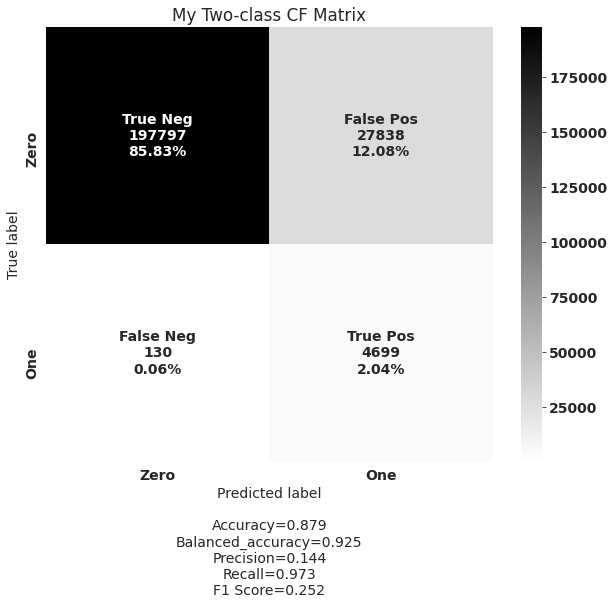

In [264]:

model_1 = LogisticRegression(C= 3, penalty= 'l2',solver='lbfgs',class_weight='balanced', n_jobs=-1)
model_2 = BalancedRandomForestClassifier(n_estimators=200,
                                             class_weight={1: 1, 0: 5},
                                             sampling_strategy='not minority',
                                             n_jobs=-1) 
pipe = Pipeline(steps=[('prep',Enc),('t1', MinMaxScaler()),('m',model_2)])
# Scaling
'''sc = MinMaxScaler() 

X_train_enc    = Enc.fit_transform(X_train_top, y_train)
X_train_enc    = sc.fit_transform(X_train_enc)

X_test_enc    = Enc.transform(X_test_top)
X_test_enc    = sc.transform(X_test_enc)'''

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

cf_matrix = confusion_matrix(y_test, predictions)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title='My Two-class CF Matrix')

#### __Error Analysis__


In [145]:
train_N = X_train.copy()

train_N['y_train']=y_train
train_N['predictions_']=predictions_

FN= train_N.query('y_train ==1 & predictions_==0')
FP= train_N.query('y_train ==0 & predictions_==1')

FN.drop(['predictions_'], axis=1, inplace=True)
FP.drop(['predictions_'], axis=1, inplace=True)
df3 = X_train.copy()
df3['y_train'] = y_train

frames = [FN, FP, df3]

result = pd.concat(frames)
result.drop_duplicates(subset=top_70_features, keep = 'first', inplace = True)
X_train_, y_train_ = result.drop(['y_train'],   axis=1) , result['y_train']

pipeline.fit(X_train_, y_train_)
pred = pipeline.predict(X_test)

cf_matrix = confusion_matrix(y_test, pred)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title=target+' classification CF Matrix')

pred_ = pipeline.predict(X_train_)
cf_matrix = confusion_matrix(y_train_, pred_)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title=target+' classification CF Matrix')

(2233, 72)

In [ ]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

#### __Finalize Model¶__


In [44]:
#target_enc_cols = ['cward', 'ecomplaintcode', 'pdiag', 'unitcode'] 
one_hot_cols    = ['csource', 'cadmitclass', 'state']
target = 'met'

top_70_features= ['cward','pdiag','unitcode','age_range','sa4','ecomplaintcode','creatinine',
                  'etriage','hb','frailty','wcc','ser','sadd','seo','hiout','srsd','platelets',
                  'ip24m','lactate','combinedscore','bicarb','male','ip12m','elective','ph','cts',
                  'transin','cadmitclass_EAD','ed24m','cadmitclass_O','ed12m','csource_HME',
                  'csource_HWL','pcomorbid','nsurg','ort','cpvthlth','genmed','vascular','outlier','ent',
                  'edvisit','c_dmcc','card','state_VIC','edany','state_NSW','c_cancer','gensurg',
                  'cadmitclass_EMD','charlsum','indig','ipany','charl3','c_pvd','c_mi','c_chf',
                  'c_cvd','statin','c_dmnc','renal','nhin',
                  'state_TAS','csource_N','c_renal','c_dementia','stroke'] 

df_train, df_test, target_enc_cols = mimic_prepare_DF(df_tr,df_tst, top_70_features, one_hot_cols, target)

with pd.option_context('display.max_colum', None):
    display(df_train.tail(1))
    display( df_test.tail(1))


(1/3) Completed One hot encoding
(2/3) Copmleted top feature selection
(3/3) Completed column reordering


,cward,pdiag,unitcode,ecomplaintcode,age_range,sa4,creatinine,etriage,hb,frailty,wcc,ser,sadd,seo,hiout,srsd,platelets,ip24m,lactate,combinedscore,bicarb,male,ip12m,elective,ph,cts,transin,cadmitclass_EAD,ed24m,cadmitclass_O,ed12m,csource_HME,csource_HWL,pcomorbid,nsurg,ort,cpvthlth,genmed,vascular,outlier,ent,edvisit,c_dmcc,card,state_VIC,edany,state_NSW,c_cancer,gensurg,cadmitclass_EMD,charlsum,indig,ipany,charl3,c_pvd,c_mi,c_chf,c_cvd,statin,c_dmnc,renal,nhin,state_TAS,csource_N,c_renal,c_dementia,stroke,met
674274,EMU,M75.1,ESS,DIA,8,206.0,166,4.0,131,8.7,7.6,3.0,9.0,10.0,0,8.0,276,2,1.0,4.0,30,0,2,0,7.4,0,0,0,1,0,1,1,0,0.0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,cward,pdiag,unitcode,ecomplaintcode,age_range,sa4,creatinine,etriage,hb,frailty,wcc,ser,sadd,seo,hiout,srsd,platelets,ip24m,lactate,combinedscore,bicarb,male,ip12m,elective,ph,cts,transin,cadmitclass_EAD,ed24m,cadmitclass_O,ed12m,csource_HME,csource_HWL,pcomorbid,nsurg,ort,cpvthlth,genmed,vascular,outlier,ent,edvisit,c_dmcc,card,state_VIC,edany,state_NSW,c_cancer,gensurg,cadmitclass_EMD,charlsum,indig,ipany,charl3,c_pvd,c_mi,c_chf,c_cvd,statin,c_dmnc,renal,nhin,state_TAS,csource_N,c_renal,c_dementia,stroke,met
93935,EOU,-1,ESS,-1,6,206.0,81,6.0,173,-1.0,6.5,1.0,3.0,9.0,0,1.0,236,0,1.5,-1.0,25,1,0,1,7.4,0,0,0,0,0,0,1,0,-1.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(674246, 68)


In [57]:
# Train and test split
X_train, y_train = df_train.drop(  [target], axis=1) , df_tr  [target]
X_test,  y_test  = df_test.drop([target], axis=1) , df_test[target]

encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), target_enc_cols )], remainder='passthrough')
scaler  = MinMaxScaler()

#target_enc_cols_new = [cat for cat in target_enc_cols if cat in top_70_features]
final_model = LogisticRegression(C= 3, penalty= 'l2',solver='lbfgs',class_weight='balanced', n_jobs=-1)
pipeline  = Pipeline(steps=[('t',encoder),('s', scaler),('m',final_model)])

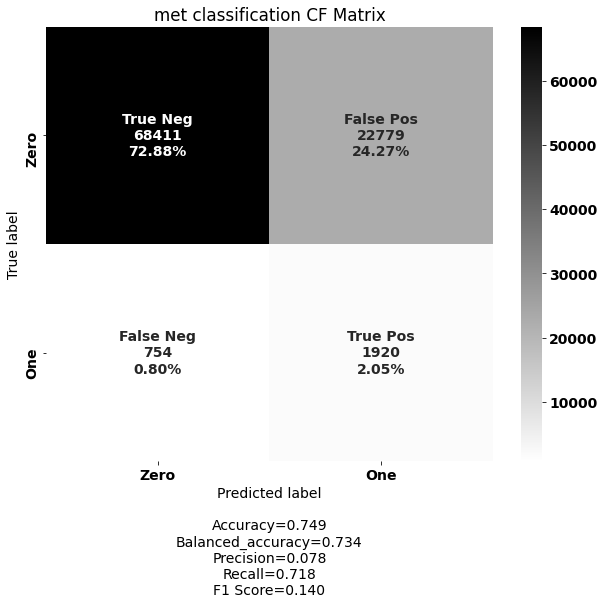

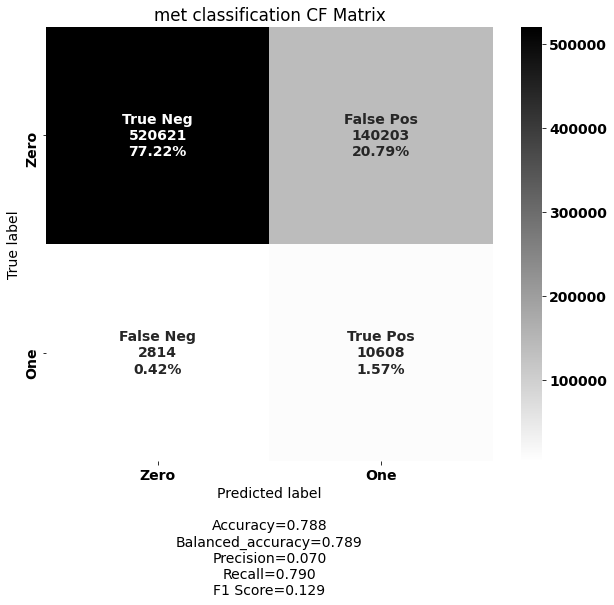

In [49]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

cf_matrix = confusion_matrix(y_test, predictions)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title=target+' classification CF Matrix')

predictions_ = pipeline.predict(X_train)
cf_matrix = confusion_matrix(y_train, predictions_)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title=target+' classification CF Matrix')